In [1]:
import xarray as xr
import parcels
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import glob
import numpy as np
from glob import glob
import os
import pprint
import math

# try conversion wind data
# conversion of data from nans to zeros does not solve the issue
# try shifting coordinates
# also did not work so something else is off : ( 


In [2]:
directory_phy =  '/storage/shared/oceanparcels/input_data/MOi/'
phy_base_file =  directory_phy + 'GLO12/psy4v3r1-daily_{vector:s}_{y:04d}-{m:02d}-{d:02d}.nc' 
phy_files_U = []
phy_files_V = []

starttime = datetime(2024,11,1)
endtime = datetime(2025,1,1)
dtime = timedelta(days=1)
time = starttime
phy_file_W = directory_phy + 'GLO12/psy4v3r1-daily_{vector:s}_{y:04d}-{m:02d}-{d:02d}.nc'.format(vector = 'W', y = time.year, m = time.month, d = time.day)
while(time < endtime):
    phy_files_U.append(phy_base_file.format(vector = 'U', y = time.year, m = time.month, d = time.day))
    phy_files_V.append(phy_base_file.format(vector = 'V', y = time.year, m = time.month, d = time.day))
    time+=dtime

# pprint.pprint(phy_files_U)

mesh_file_h = directory_phy + "domain_ORCA0083-N006/PSY4V3R1_mesh_hgr.nc"
mesh_file_z = directory_phy + "domain_ORCA0083-N006/PSY4V3R1_mesh_zgr.nc"
filenames_phy = {'U': {
        'lon': mesh_file_h,
        'lat': mesh_file_h,
       'depth':phy_file_W,
        'data': phy_files_U,
    }, 'V': {
        'lon': mesh_file_h,
        'lat': mesh_file_h,
       'depth':phy_file_W,
        'data': phy_files_V,
    }
}
variables_phy = {'U': 'vozocrtx',
                'V': 'vomecrty'}

c_grid_dimensions = {'lat': 'gphif',
                 'lon': 'glamf',
                 'depth':'depthw',
                 'time': 'time_counter'}

dimensions_phy = {'U': c_grid_dimensions,
                 'V': c_grid_dimensions}

fieldset = parcels.FieldSet.from_nemo(filenames_phy,variables_phy,dimensions_phy)
# fieldset.add_periodic_halo(zonal=True)

In [ ]:
print(fieldset.U.data.shape)

In [ ]:


# fieldset.computeTimeChunk()

# plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,0, :, :])
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.colorbar()
# plt.show()



In [13]:
wind_files = ['/storage/shared/oceanparcels/input_data/ERA5/reanalysis-era5-single-level_wind10m_202411.nc','/storage/shared/oceanparcels/input_data/ERA5/reanalysis-era5-single-level_wind10m_202412.nc']
filenames_wind = {'U_wind': wind_files,
                    'V_wind': wind_files}
variables_wind = {'U_wind': 'u10',
                    'V_wind': 'v10'}
dimensions_wind = {'lat': 'latitude',
                    'lon': 'longitude',
                    'time': 'valid_time'}


ds_wind = xr.open_mfdataset(wind_files)

fieldset_wind = parcels.FieldSet.from_xarray_dataset(ds_wind, variables_wind,dimensions_wind, mesh='spherical')
fieldset_wind.add_periodic_halo(zonal=True)
fieldset_wind.U_wind.units = parcels.GeographicPolar()
fieldset_wind.V_wind.units = parcels.Geographic()




fieldset.add_field(fieldset_wind.U_wind)
fieldset.add_field(fieldset_wind.V_wind)
fieldset.add_constant('windage',0.1)

# fieldset_wind.computeTimeChunk(0,1)
# print(fieldset_wind.U_wind[0,0,0,0])

RuntimeError: FieldSet has already been completed. Are you trying to add a Field after you've created the ParticleSet?

In [14]:
#def wind kernel
def wind_drag(particle, fieldset, time):

    (curr_U, curr_V) = fieldset.UV[particle]
   
    ocean_speed = math.sqrt(curr_U**2 + curr_V**2)
    
    
    if ocean_speed > 1E-14:
        print( ocean_speed)
        # Sample the U / V components of wind
        wind_U = fieldset.U_wind[time, particle.depth, particle.lat, particle.lon]
        wind_V = fieldset.V_wind[time, particle.depth, particle.lat, particle.lon]

        # compute particle displacement
        particle_dlon += fieldset.windage * wind_U * particle.dt
        particle_dlat += fieldset.windage * wind_V * particle.dt 

In [17]:
pset = parcels.ParticleSet.from_list(fieldset,
                                     parcels.JITParticle,
                                     lon=[-30],
                                     lat=[0],
                                     time=datetime(2024,11,2))

output_file = pset.ParticleFile(
    name="test.zarr",  # the name of the output file
    outputdt=3600,  # the time period between consecutive out output steps
    chunks=(1, 10),  # the chunking of the output file (number of particles, timesteps)
)

In [18]:
pset.execute([parcels.AdvectionRK4],
             runtime=timedelta(days=1),
             dt=timedelta(seconds=3600),
             output_file=output_file)

INFO: Output files are stored in test.zarr.
100%|██████████| 86400.0/86400.0 [02:21<00:00, 612.55it/s]


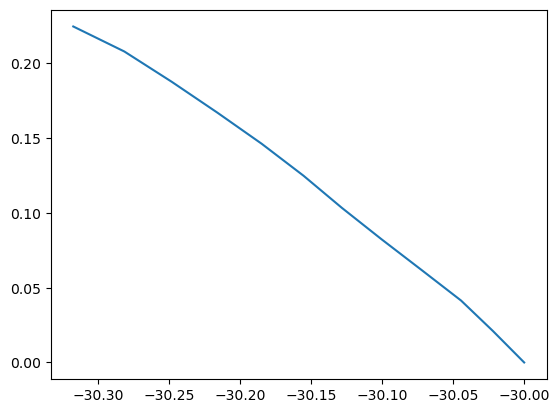

In [11]:
ds_particles = xr.open_zarr('test.zarr')
fig,ax=plt.subplots()
ax.plot(ds_particles.lon.T,ds_particles.lat.T)



In [12]:
print(ds_particles.lat.values)

[[0.         0.02100315 0.041416   0.0616462  0.08237033 0.1033786
  0.12490237 0.146247   0.16700632 0.18768027 0.2079507  0.22467999
         nan        nan        nan        nan        nan        nan
         nan        nan]]
